In [1]:
import pandas as pd
import os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from epftoolbox.evaluation import MAE, MAPE, RMSE, rMAE
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
os.chdir('..')

In [3]:
# Funciones auxiliares
# Romper el dataset
def train_test_vali(serie, train_size, valida_size, ts_size):
    total_data = serie.shape[0]

    train_data = int(total_data * train_size)
    valid_data = int(total_data * valida_size)
    test_data = total_data - train_data - valid_data

    train = serie[0:train_data]
    vali = serie[train_data:train_data + valid_data]
    test = serie[train_data + valid_data:]
    return train, vali, test

#Crear dataset supervisado
def to_sequences(SEQUENCE_SIZE, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

# Auxiliares del modelo
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Función para medir el tiempo de ejecución
def elapsed_time(start_time):
    return time.time() - start_time

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

620/620 [==============================] - 4s 6ms/step
(0.7, 0.2, 0.1)


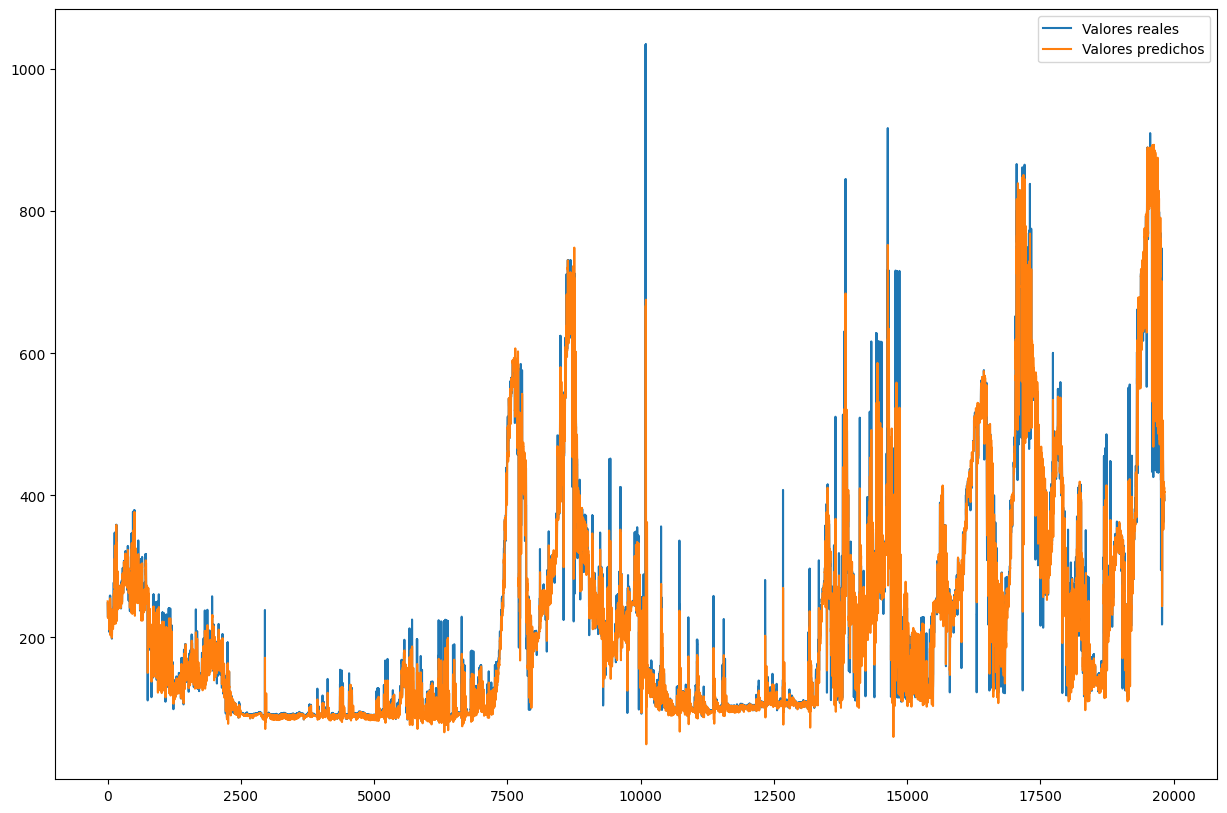

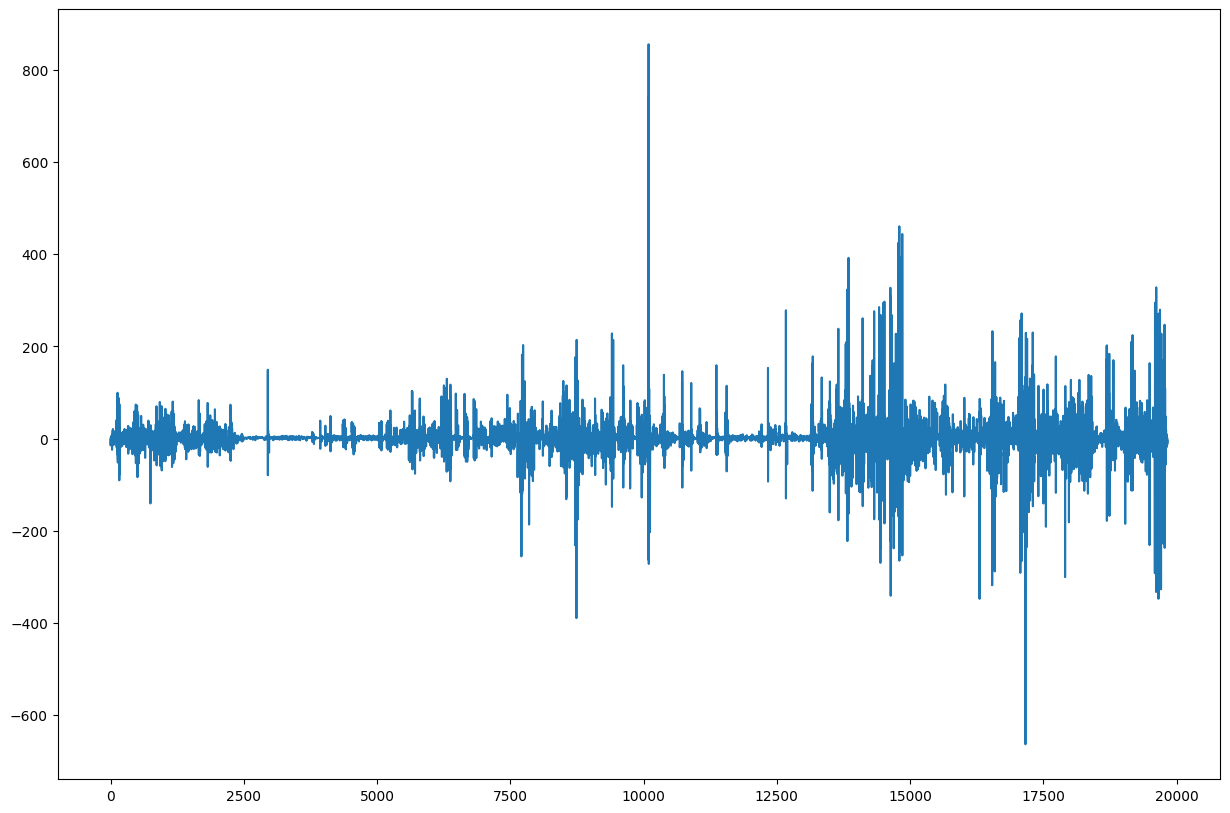

620/620 [==============================] - 5s 7ms/step
(0.8, 0.1, 0.1)


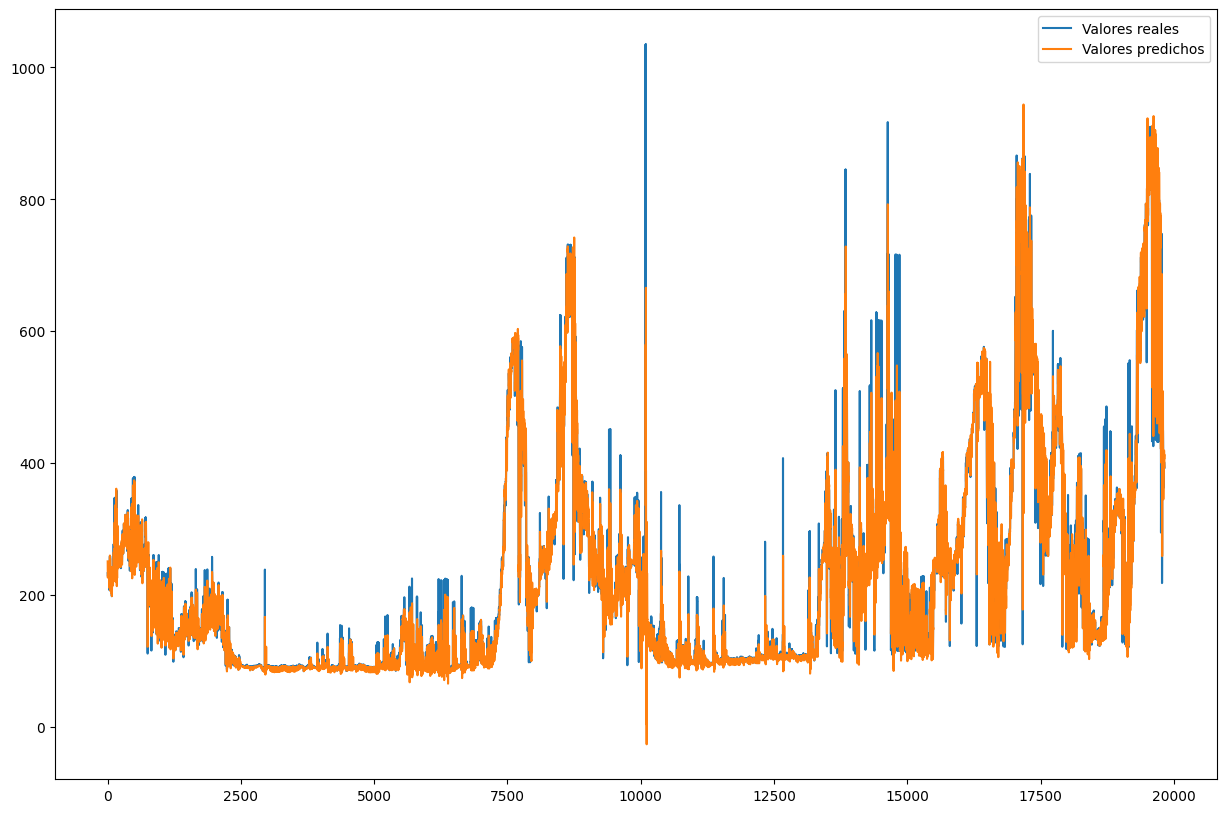

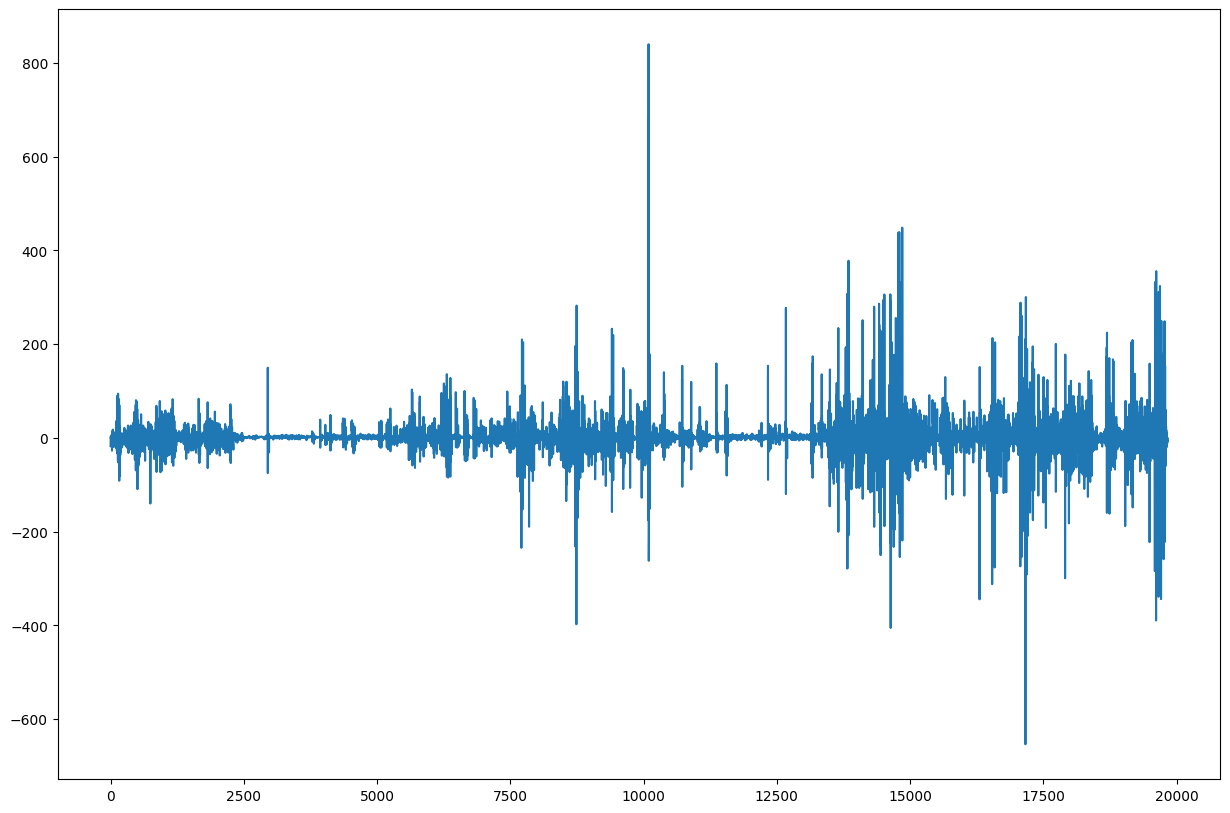

310/310 [==============================] - 3s 8ms/step
(0.9, 0.05, 0.05)


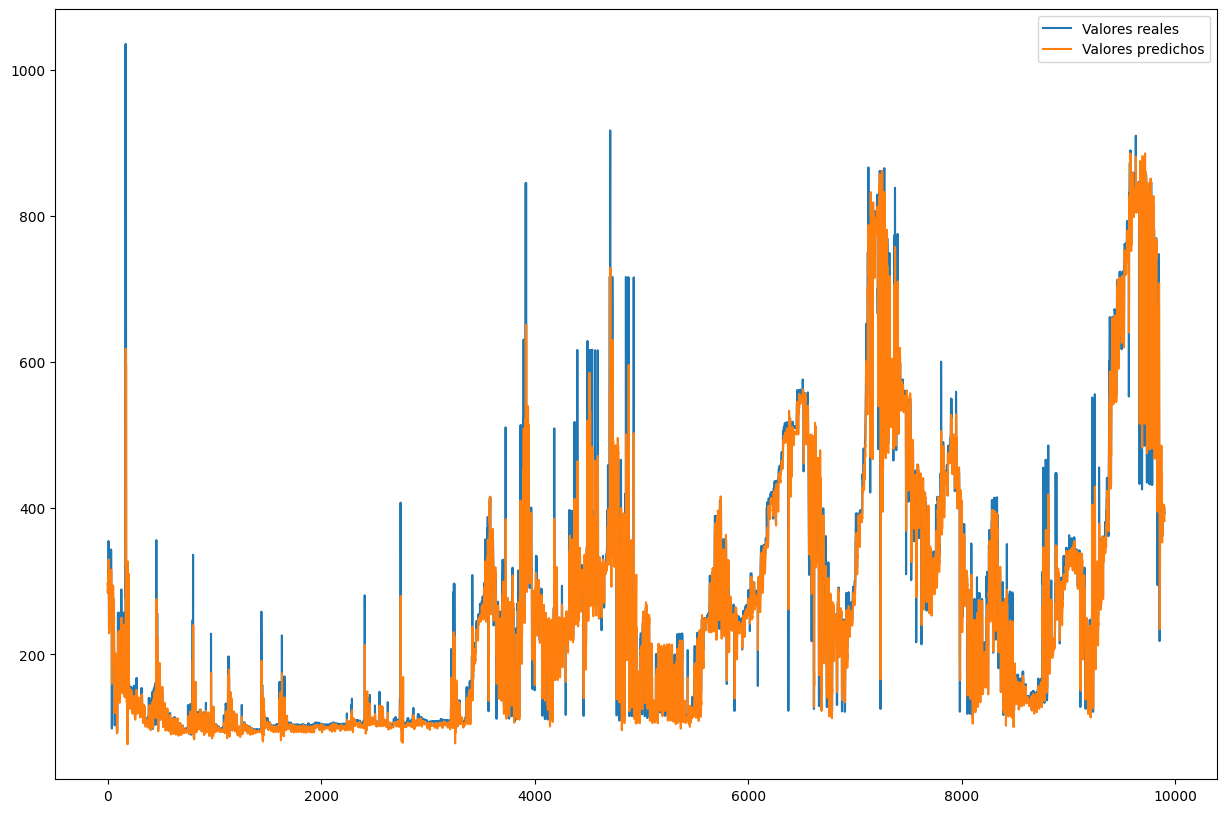

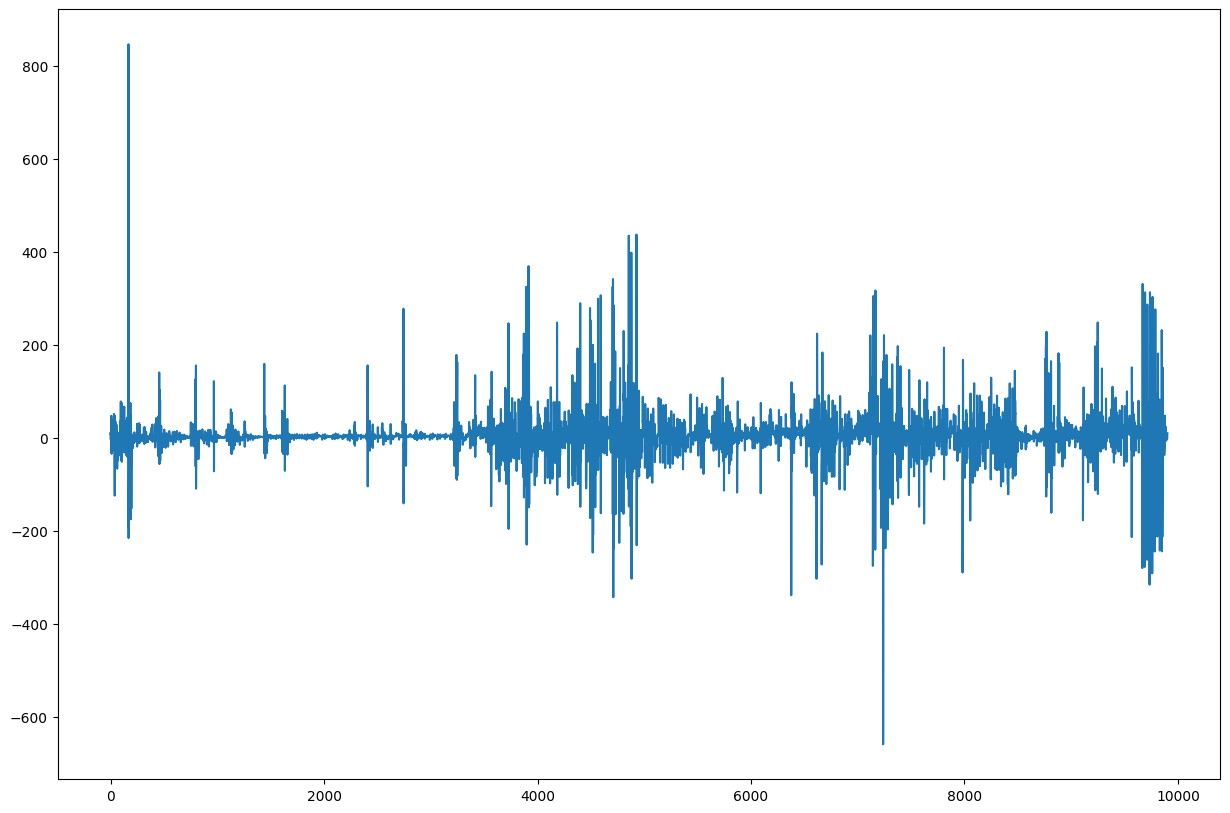

In [5]:
# Crear diferentes modelos base para cada tipo de particion
types = [(0.7,0.2,0.1),(0.8,0.1,0.1),(0.9,0.05,0.05)]
#tf.random.set_seed(123)
lista_results = []
INPUT_LENGTH = 24    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 24   # El modelo va a predecir 24 horas a futuro
for i in types:
    scaler = MinMaxScaler()
    df = pd.read_csv('df_data_colum.csv', parse_dates=['date_hour'], index_col='date_hour')
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    tr, vl, ts = train_test_vali(df_scaled['price'], i[0], i[1], i[2])

    x_tr, y_tr = to_sequences(OUTPUT_LENGTH, tr.values)
    x_vl, y_vl = to_sequences(OUTPUT_LENGTH, vl.values)
    x_ts, y_ts = to_sequences(OUTPUT_LENGTH, ts.values)

    input_shape = x_tr.shape[1:]

    model = tf.keras.models.load_model('enconder_model/bases_model/model_{train_size}.h5'.format(train_size=i[0]),
                                        custom_objects={'root_mean_squared_error': root_mean_squared_error})

    # rmse_tr = model.evaluate(x_tr, y_tr, verbose=0)
    # rmse_vl = model.evaluate(x_vl, y_vl, verbose=0)
    # rmse_ts = model.evaluate(x_ts, y_ts, verbose=0)

    start_time = time.time()
    y_ts_pred = model.predict(x_ts)
    prediction_time = elapsed_time(start_time)
    test = pd.DataFrame(data = {'predictions':y_ts_pred.reshape(-1), 'actual':y_ts}, index=ts[24:].index)
    df_result = pd.DataFrame(scaler.inverse_transform(test), columns=test.columns)

    print(i)
    x = df_result.index
    plt.figure(figsize=(15, 10))
    plt.plot(x, df_result['actual'], label='Valores reales')
    plt.plot(x, df_result['predictions'], label='Valores predichos')
    plt.legend()
    plt.show()

    # Grafico de error 
    df_result['error'] = df_result['actual'] - df_result['predictions']
    plt.figure(figsize=(15, 10))
    plt.plot(df_result['error'])
    plt.show()

#     if i[0] == 0.7:
#         training_time = 1219.23
#     elif i[0] == 0.8:
#         training_time = 791.46
#     else:
#         training_time = 866.63

#     mean_MAE = MAE(p_pred= df_result['predictions'], p_real=df_result['actual'])
#     mean_RMSE = RMSE(p_pred= df_result['predictions'], p_real=df_result['actual'])
#     mean_MAPE = MAPE(p_pred= df_result['predictions'], p_real=df_result['actual']) * 100
#     r2 = metrics.r2_score(df_result['actual'], df_result['predictions'])

#     results = {'trainig_size': i[0], 'model': 'transformer', 'type': 'base', 'training_time': training_time, 
#                'prediction_time': prediction_time, 'rmse_trainig': rmse_tr, 'rmse_validation': rmse_vl, 'rmse_test': rmse_ts, 
#                'mean_MAE': mean_MAE,  'r2': r2, 'mean_RMSE': mean_RMSE, 'mean_MAPE': mean_MAPE}
    
#     lista_results.append(results)

# df_results_bases = pd.DataFrame(lista_results)
# df_results_bases.to_csv('enconder_model/bases_model/df_results_bases.csv')